In [2]:
import numpy as np
import pandas as pd
from skimage import io
import cv2
import random
import os
import shutil
import glob
import matplotlib.pyplot as plt

# Loading the model

In [3]:
from ultralytics import YOLO

model = YOLO('YoloModelFiles/best.pt')  # load a pretrained model (recommended for training)

# Make Predictions

In [4]:
path = 'Images/measured_images'
images = glob.glob( path + '/*.jpg')


image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\measured_images\50.jpg: 640x640 1 Box, 359.8ms
Speed: 11.3ms preprocess, 359.8ms inference, 25.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\measured_images\20.jpg: 640x640 1 Box, 259.6ms
Speed: 0.0ms preprocess, 259.6ms inference, 29.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\measured_images\50.jpg: 640x640 1 Box, 279.3ms
Speed: 7.4ms preprocess, 279.3ms inference, 17.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\measured_images\20.jpg: 640x640 1 Box, 274.9ms
Speed: 0.0ms preprocess, 274.9ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\measured_images\90.jpg: 640x640 1 Box, 260.1ms
Speed: 0.0ms preprocess, 260.1ms inference, 15.5ms postprocess per i

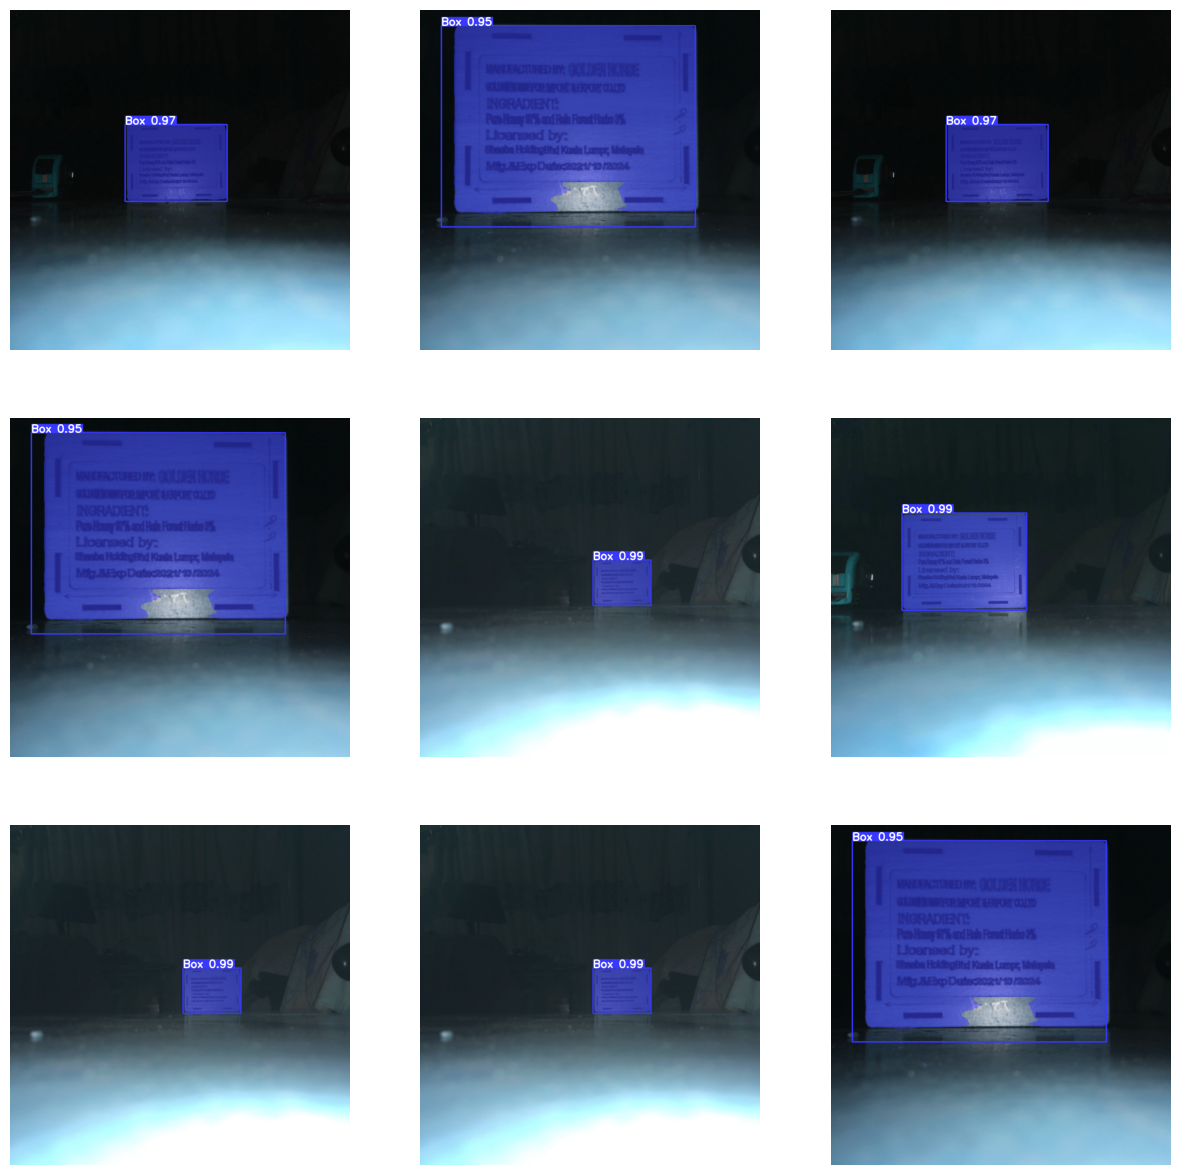

In [5]:
plt.figure(figsize=(15,15))
for plot_index in range(9):

    index  = random.randint(0, len(images) - 1)

    image_path = images[index]
    img = cv2.imread(image_path)

    results = model(image_path, conf = 0.95)[0]


    plt.subplot(3,3, plot_index +1)
    plt.imshow(results.plot())
    plt.axis('off')

# Getting Box Corners

In [137]:
path = 'Images'
images = glob.glob( path + '/*.jpg')
image_path = images[1]

In [26]:
def GetMask(image_path, 
            model_path= 'c:/Users/LENOVO/Desktop/Depth Measurement/YoloModelFiles/best.pt'):
    '''
    this function returns a list of binary masks using yolo segmentation

    '''

    model = YOLO(model_path)
    results = model(image_path, conf = 0.95)[0]
    masks = results.masks.data
    
    return np.array(masks, dtype='uint8')

In [124]:
masks = GetMask(images[1])


image 1/1 c:\Users\LENOVO\Desktop\Depth Measurement\Images\image2.jpg: 640x640 1 Box, 204.4ms
Speed: 4.7ms preprocess, 204.4ms inference, 9.9ms postprocess per image at shape (1, 3, 640, 640)


In [28]:
def GetCorners(mask):
    '''
    this function returns the detected corners using harris corner detection on a binary mask
    '''

    grayfloatimg = np.float32(mask)
    rscores = cv2.cornerHarris(grayfloatimg, 8, 5, 0.07)

    rscores = cv2.dilate(rscores,None)
    threshold = 0.01*rscores.max()

    return (rscores>threshold), rscores

image = cv2.imread(image_path)
image = cv2.resize(image, (640,640))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

corners, rscores = GetCorners(masks[0])
img = image.copy() 
img[corners] = [0,255,0]

In [29]:
def GetMinBBox(mask):
    '''
    this function returns the minimum (rotated) box corners using a binary mask
    '''
    contours, hierarchy  = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = tuple(sorted(contours, key=cv2.contourArea , reverse=True))

    rect = cv2.minAreaRect(contours[0])
    box = np.intp(cv2.boxPoints(rect))
    return box

box = GetMinBBox(masks[0])
im = image.copy()

im = cv2.drawContours(im, [box], -1, (0, 255, 0), 1)

(-0.5, 639.5, 639.5, -0.5)

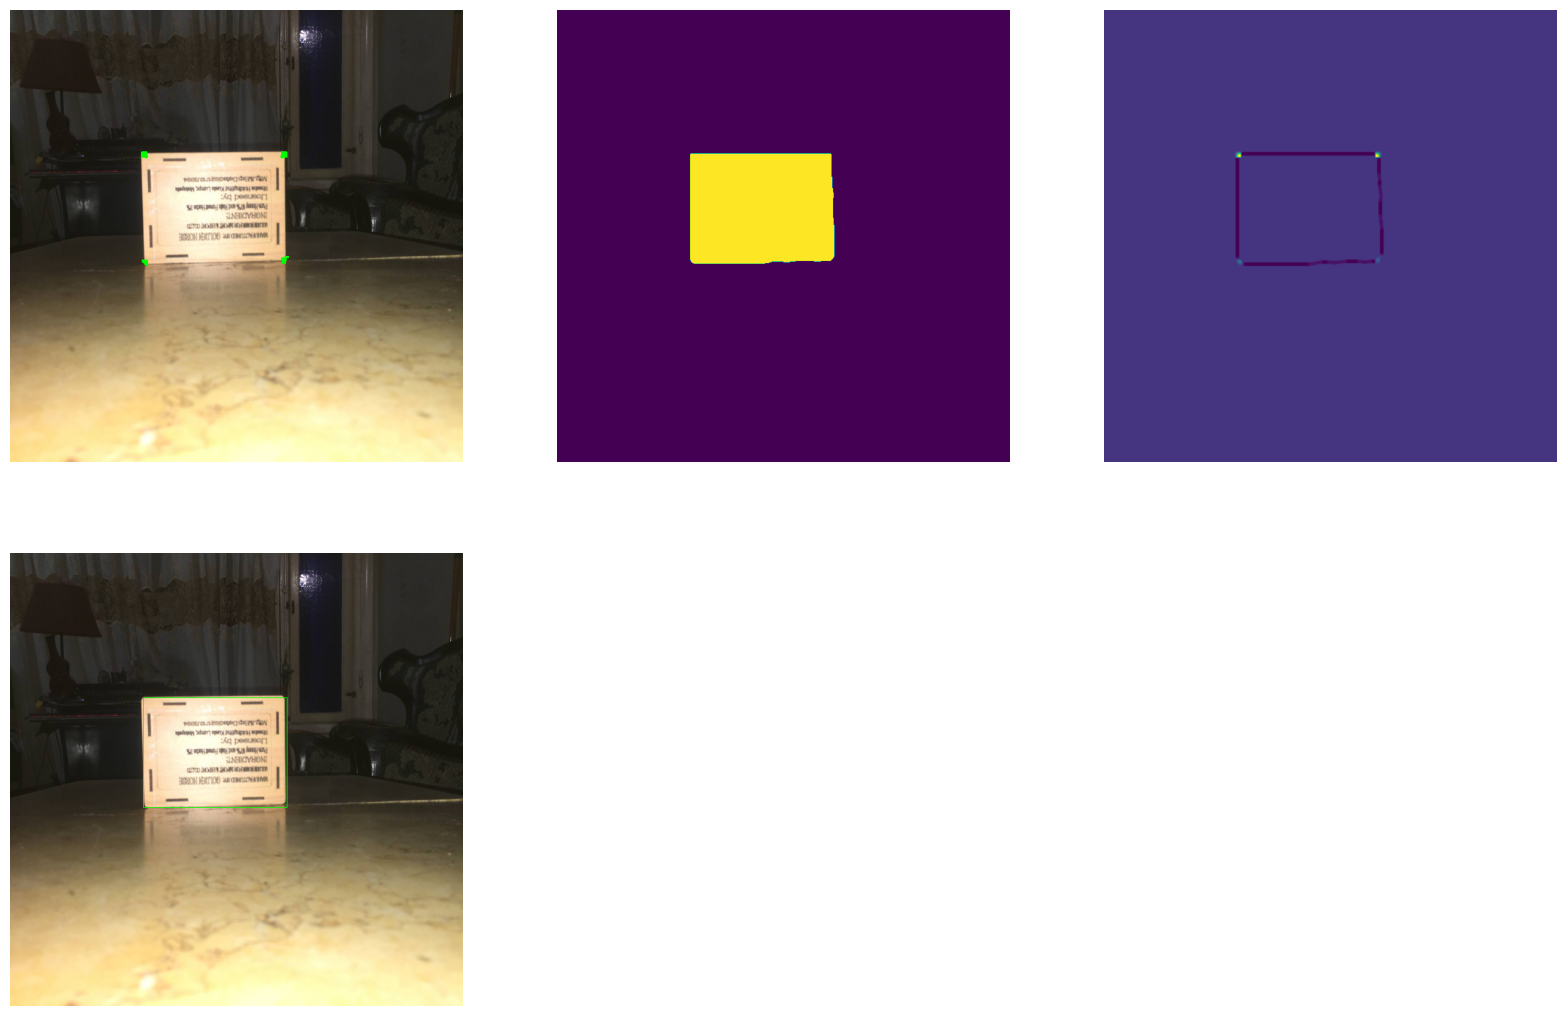

In [30]:
plt.figure(figsize=(20,20))

plt.subplot(3,3, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(3,3, 2)
plt.imshow(masks[0])
plt.axis('off')

plt.subplot(3,3, 3)
plt.imshow(rscores)
plt.axis('off')

plt.subplot(3,3, 4)
plt.imshow(im)
plt.axis('off')


In [135]:
class WoodenBox:
    def __init__(self,
               image        = None,
               weights_path = 'c:/Users/LENOVO/Desktop/Depth Measurement/YoloModelFiles/best.pt',
               mask_shape = 640,
               conf = 0.95):
        '''
        using yolo model trained weights this class detects woodenbox and return its bounding box

        @params
            image (ndarray 640,640) or (string): specify input image or image path
            conf                               : yolo model confidence
        '''
        
        self.image = image
        self.weights_path = weights_path
        self.mask_shape = mask_shape
        self.masks = None
        self.conf = conf
        self.box = None
        self.sucess = 0
    
    def run(self):
        self.GetMask()
        
        if (self.sucess):
            self.GetMinBBox()

        return self.box

        
    def GetMask(self):
        '''
        this function returns a list of binary masks using yolo segmentation

        '''
        model = YOLO(self.weights_path)
        results = model(self.image, conf = self.conf, verbose=False)[0]
        if (results.masks) != None:
            self.sucess = 1
            self.masks = results.masks.data
            self.masks =  np.array(self.masks, dtype='uint8')
        else:
            self.sucess = 0

    def GetCorners(self):
        '''
        this function returns the detected corners using harris corner detection on a binary mask
        '''

        grayfloatimg = np.float32(self.masks[0])
        rscores = cv2.cornerHarris(grayfloatimg, 8, 5, 0.07)

        rscores = cv2.dilate(rscores,None)
        threshold = 0.01*rscores.max()

        return (rscores>threshold)
    
    def GetMinBBox(self):
        '''
        this function returns the minimum (rotated) box corners using a binary mask
        '''
        contours, hierarchy  = cv2.findContours(self.masks[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = tuple(sorted(contours, key=cv2.contourArea , reverse=True))

        rect = cv2.minAreaRect(contours[0])
        self.box = np.intp(cv2.boxPoints(rect))

In [110]:
images

['Images\\image1.jpg',
 'Images\\image2.jpg',
 'Images\\photo_2023-12-13_02-49-28.jpg',
 'Images\\photo_2023-12-13_02-49-34.jpg',
 'Images\\photo_2023-12-13_02-49-37.jpg',
 'Images\\photo_2023-12-13_02-49-41.jpg',
 'Images\\photo_2023-12-13_02-49-45.jpg',
 'Images\\photo_2023-12-13_02-49-48.jpg',
 'Images\\photo_2023-12-13_02-49-51.jpg',
 'Images\\photo_2023-12-13_02-49-57.jpg',
 'Images\\photo_2023-12-13_02-50-02.jpg',
 'Images\\photo_2023-12-13_02-50-07.jpg',
 'Images\\photo_2023-12-13_02-50-10.jpg',
 'Images\\photo_2023-12-13_02-50-13.jpg',
 'Images\\photo_2023-12-13_02-50-15.jpg',
 'Images\\photo_2023-12-13_02-50-18.jpg',
 'Images\\photo_2023-12-13_02-50-21.jpg',
 'Images\\photo_2023-12-13_02-50-24.jpg']

In [140]:
image = cv2.imread(images[1])
image = cv2.resize(image, (640,640))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

wooden = WoodenBox()
wooden.image = image
bbox = wooden.run()
if type(bbox) != type(None) :
    im = cv2.drawContours(image, [bbox], -1, (0, 255, 0), 1)

In [141]:
wooden.sucess

1

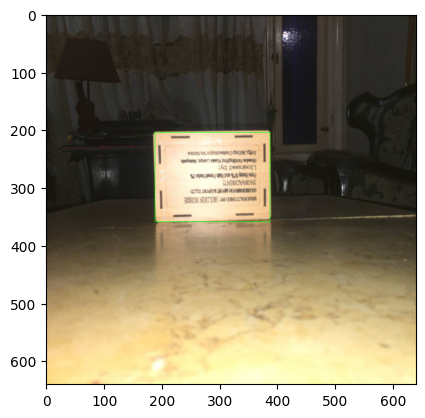

In [142]:
plt.imshow(image)

In [143]:
y = [90 ,30, 20]
x = [107, 231, 455]

coefficients = np.polyfit(x,y, 3)
poly_function = np.poly1d(coefficients)
dist = poly_function((bbox[1] - bbox[0])[0])

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3398: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [144]:
dist

43.30932447947525

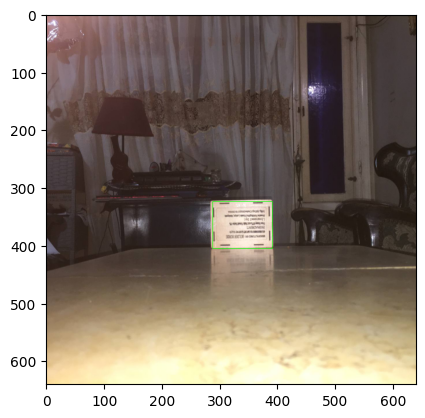

In [97]:
plt.imshow(im)